## Loading Libraries

In [ ]:
import os

import numpy as np
from numpy.random import choice
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import time

import PIL

import torch
from torch import nn, Tensor
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torchvision


# For AUC:
from sklearn.metrics import roc_auc_score


np.random.seed(42)

## Helper functions
### Timing

In [ ]:
def function_timer(function):
    
    def wrapper(*args, **kwargs):
        start    = time.time()
        result   = function(*args, **kwargs)
        duration = time.time() - start
        
        hours    = int(duration // 60**2)
        minutes  = int((duration % 60**2) // 60)  
        seconds  = int(duration % 60)
        print(f'execution-time of function "{function.__name__}": {hours}h {minutes}m {seconds}s')
        
        return result
        
    return wrapper


### Plot learning curves

In [ ]:
def plot_error_curves(errors_over_time: list, error_name='error'):
    """
    @ errors_over_time: list of tuples: (training-error, validation-error)
    """

    if len(errors_over_time) <= 1:
        print(f'Require at least two data-poits for plotting. Got {len(errors_over_time)}.')
        return 0
    
    error_train, error_validation = zip(*errors_over_time)

    plt.plot(range(len(error_train)), error_train)
    plt.plot(range(len(error_validation)), error_validation)
    plt.xticks(range(0, len(error_train) + 1, len(error_train) // 2))
    plt.xlabel('epoch')
    plt.ylabel(f'{error_name}')
    plt.legend(('training', 'validation'))
    plt.title(f'{error_name} over time')
    plt.show();

# Data preparation
## Set directories and train/validaton split

In [ ]:
DATA_DIR = '../input'

train_dir = os.path.join(DATA_DIR, 'train')
test_dir  = os.path.join(DATA_DIR, 'test')


def train_validation_split(df, val_fraction=0.1):
    val_ids  = np.random.choice(df.id, size=int(len(df) * val_fraction))
    val_df   = df.query('id     in @val_ids')
    train_df = df.query('id not in @val_ids')
    return train_df, val_df


train_label_df, val_label_df = train_validation_split(pd.read_csv(os.path.join(DATA_DIR, 'train_labels.csv')),
                                                      val_fraction=0.1)

## Dataset Class

In [ ]:
class HistoPatches(Dataset):
    
    def __init__(self,
                 image_dir: str,
                 label_df=None,
                 transform=transforms.ToTensor(),
                 sample_n=None,
                 in_memory=False):
        """
        @ image_dir:   path to directory with images
        @ label_df:    df with image id (str) and label (0/1) - only for labeled test-set
        @ transforms:  image transformation; by default no transformation
        @ sample_n:    if not None, only use that many observations
        """
        self.image_dir = image_dir
        self.img_files = os.listdir(image_dir)
        self.label_df  = label_df
        self.transform = transform
        self.in_memory = in_memory
        
        if sample_n and label_df is None:
            print('subsampling is currently only implemented when a label-dataframe is provided.')
            print('(because training- and validation-set share the same image directory')
            print('and the test-set does not need to be subsampled)')
        elif sample_n:
            self.label_df  = self.label_df.sample(n=sample_n)
            ids            = set(self.label_df.id)
            self.img_files = [f for f in self.img_files if f.split('.')[0] in ids]
            
        #self.label_df = self.label_df.reset_index(drop=True)
            
        if in_memory:
            self.id2image = self._load_images()

        print(f'Initialized datatset with {len(self.img_files)} images.\n')
        
    @function_timer
    def _load_images(self):
        print('loading images in memory...')
        id2image = {}
        
        for file_name in self.img_files:
            img = PIL.Image.open(os.path.join(self.image_dir, file_name))
            X   = self.transform(img)
            id_ = file_name.split('.')[0]
            id2image[id_] = X
            
        return id2image
    
    def __getitem__(self, idx):
        file_name = self.img_files[idx]
        id_ = file_name.split('.')[0]
        
        #row = self.label_df.iloc[idx]
        #assert row.label == self.label_df.loc[idx].label
        #y   = float(row.label)
        
        if self.in_memory:
            X = self.id2image[id_]
        else:
            img = PIL.Image.open(os.path.join(self.image_dir, file_name))
            X   = self.transform(img)
            
        if self.label_df is not None:
            y = float(self.label_df.query('id == @id_').label)
            return X, y
        else:
            return X, id_
    
    def __len__(self):
        return len(self.img_files)
    


## Load Data into RAM

In [ ]:
image_trans = transforms.Compose([#transforms.CenterCrop(30),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.70017236, 0.5436771, 0.6961061], 
                                                       std=[0.22246036, 0.26757348, 0.19798167])
                                 ])
memory      = True
batchsize   = 64

train = HistoPatches(train_dir,
                     train_label_df,
                     transform=image_trans,
                     sample_n=70000, #70k was best
                     in_memory=memory)

val   = HistoPatches(train_dir,
                     val_label_df,
                     transform=image_trans,
                     sample_n=4000,
                     in_memory=memory)

train_loader = DataLoader(train, batch_size=batchsize, shuffle=True)
val_loader   = DataLoader(val,   batch_size=batchsize, shuffle=False)

print('test and show batch-dimension:')
for i, (X, y) in enumerate(train_loader):
    if i == 10:
        print(X.shape, y.shape)
        break

# Cyclic Learning Rate Class

In [ ]:
class CyclicLR(object):
    def __init__(self, optimizer, base_lr=1e-3, max_lr=6e-3,
                 step_size=2000, mode='triangular', gamma=1.,
                 scale_fn=None, scale_mode='cycle', last_batch_iteration=-1):

        
        self.optimizer = optimizer

        if isinstance(base_lr, list) or isinstance(base_lr, tuple):
            if len(base_lr) != len(optimizer.param_groups):
                raise ValueError("expected {} base_lr, got {}".format(
                    len(optimizer.param_groups), len(base_lr)))
            self.base_lrs = list(base_lr)
        else:
            self.base_lrs = [base_lr] * len(optimizer.param_groups)

        if isinstance(max_lr, list) or isinstance(max_lr, tuple):
            if len(max_lr) != len(optimizer.param_groups):
                raise ValueError("expected {} max_lr, got {}".format(
                    len(optimizer.param_groups), len(max_lr)))
            self.max_lrs = list(max_lr)
        else:
            self.max_lrs = [max_lr] * len(optimizer.param_groups)

        self.step_size = step_size

        if mode not in ['triangular', 'triangular2', 'exp_range'] \
                and scale_fn is None:
            raise ValueError('mode is invalid and scale_fn is None')

        self.mode = mode
        self.gamma = gamma

        if scale_fn is None:
            if self.mode == 'triangular':
                self.scale_fn = self._triangular_scale_fn
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = self._triangular2_scale_fn
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = self._exp_range_scale_fn
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode

        self.step(batch_iteration = last_batch_iteration + 1)
        self.last_batch_iteration = last_batch_iteration

    def step(self, batch_iteration = None, ):
        if batch_iteration is None:
            batch_iteration = self.last_batch_iteration + 1
        self.last_batch_iteration = batch_iteration
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

    def _triangular_scale_fn(self, x):
        return 1.

    def _triangular2_scale_fn(self, x):
        return 1 / (2. ** (x - 1))

    def _exp_range_scale_fn(self, x):
        return self.gamma**(x)

    def get_lr(self):
        step_size = float(self.step_size)
        cycle = np.floor(1 + self.last_batch_iteration / (2 * step_size))
        x = np.abs(self.last_batch_iteration / step_size - 2 * cycle + 1)

        lrs = []
        param_lrs = zip(self.optimizer.param_groups, self.base_lrs, self.max_lrs)
        for param_group, base_lr, max_lr in param_lrs:
            base_height = (max_lr - base_lr) * np.maximum(0, (1 - x))
            if self.scale_mode == 'cycle':
                lr = base_lr + base_height * self.scale_fn(cycle)
            else:
                lr = base_lr + base_height * self.scale_fn(self.last_batch_iteration)
            lrs.append(lr)
        return lrs

## Why Use AUC instead of Accuracy?

In [ ]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = '1', '0'
sizes = [np.mean(val_label_df.label), 1-np.mean(val_label_df.label)]
#explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set(title = "Test Set Label Distribution")
plt.show()

We see, the label distribution in our validation set is skewed towards label 0

# Training Routine

In [ ]:
@function_timer
def train_model(net, train, validation, optimizer, device, scheduler = None, max_epoch=100, verbose=False):
    """
    This function returns nothing. The parametes of @net are updated in-place
    and the error statistics are written to a global variable. This allows to
    stop the training at any point and still have the results.
  
    @ net: a defined model - can also be pretrained
    @ train, test: DataLoaders of training- and test-set
    @ max_epoch: stop training after this number of epochs
    """
    global error_stats  # to track error log even when training aborted
    error_stats = []
  
    criterion = nn.BCEWithLogitsLoss()
    #scheduler = torch.optim.lr_scheduler.MultiStepLR(
    #    optimizer,
    #    milestones=[x for x in range(1, max_epoch) if x % 20 == 0],
    #    gamma=0.5  # decrease learning rate by half each step
    #)
    net.to(device)
    
    print('epoch\ttraining-CE\ttraining-acc\ttraining_auc\tvalidation-CE\tvalidation-acc\tvalidation_auc')
    for epoch in range(max_epoch):
        net.train()
        training_loss = 0
        training_acc = 0
        validation_loss = 0
        validation_acc = 0
        training_auc = 0
        validation_auc = 0
    
        for batch_i, (X, y) in enumerate(train):
            
            if verbose and batch_i % (batchsize/4) == 0:
                print(f'\t...batch {batch_i} / {len(train)}')
            
            X , y = X.to(device), y.to(device)
            optimizer.zero_grad()
            if scheduler is not None:
                scheduler.step()
            # prediction and error:
            out  = net(X).squeeze()
            loss = criterion(out.type(torch.DoubleTensor).cuda(), y)  # loss of current batch
            training_loss += loss.item()
            predictions = torch.sigmoid(out).round().detach().cpu().numpy()
            training_acc += np.mean(y.detach().cpu().numpy() == predictions) * 100
            training_auc += get_roc_score(out ,y)

            # update parameters:
            loss.backward()
            optimizer.step()

        with torch.no_grad():  # no backpropagation necessary
            net.eval()

            for X, y in validation:
                X , y = X.to(device), y.to(device)

                # prediction and error:
                out  = net(X).squeeze()
                loss = criterion(out.type(torch.DoubleTensor).cuda(), y)  # loss of current batch
                validation_loss += loss.item()
                predictions = torch.sigmoid(out).round().detach().cpu().numpy()
                validation_acc += np.mean(y.detach().cpu().numpy() == predictions) * 100
                validation_auc += get_roc_score(out ,y)
    
        # convert to batch loss:
        training_acc    = training_acc    / len(train)
        training_loss   = training_loss   / len(train)
        training_auc    = training_auc    / len(train)
        validation_acc  = validation_acc  / len(validation)
        validation_loss = validation_loss / len(validation)
        validation_auc  = validation_auc  / len(validation)
        #scheduler.step()
       
        #torch.save(net.state_dict(), f'epoch{epoch}.pt')
        error_stats.append( (training_loss, validation_loss, training_acc, validation_acc, training_auc, validation_auc) )

        print('{}\t{:.4f}\t\t{:.2f}\t\t{:.4f}\t\t{:.4f}\t\t{:.2f}\t\t{:.4f}'.format(
            epoch, training_loss, training_acc, training_auc, validation_loss, validation_acc, validation_auc)
             )
        


# Model
## DenseNet121 Architecture

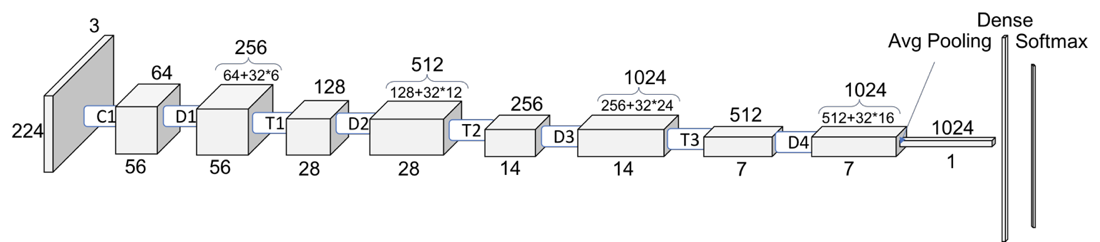

## Helper function to determine input shapes at the start of the network
We want to fit 96x96 images into a DenseNet, which expects a 224x224 image. Therefore we replace the first few layers of the DenseNet with a convolutional block that transforms the image accordingly.

In [ ]:
def conv_dim(in_dim, k=3, s=1, p=0, p_left=None, p_right=None):
    
    if p is not None:
        p_left = p_right = p
    assert p_left is not None and p_right is not None
        
    tmp = (in_dim - k + p_left + p_right) / s
    out_dim = int(np.floor(tmp) + 1)
    
    if tmp % 1 != 0:
        print('no exact output-dim; using Gauss-brackets.')
    print(f'out-dim: {out_dim}')


# conv_dim(30, k=3, s=1, p=0)

In [ ]:
#orig_net = models.densenet121()
#print(orig_net.features[:4])

#x = X.cpu()
#h1 = orig_net.features[:4](x)
#print(h1.shape)

## Alteration of the DenseNet121

In [ ]:
from collections import OrderedDict

net_fullimage = models.densenet121(pretrained=False)
net_fullimage.features = nn.Sequential(
    nn.Sequential(OrderedDict([
            ('conv0', nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1, bias=False)),
            ('norm0', nn.BatchNorm2d(64)),
            ('relu0', nn.ReLU(inplace=True))
        ])),  # 96**2 -> 48**2
    net_fullimage.features[4:])

net_fullimage.classifier = nn.Sequential(
    nn.Linear(1024, 512),
    nn.Linear(512, 1)
)
# net_fullimage

In [ ]:
net = net_fullimage  # choose net to train here

# # just for testing
# myloss = nn.BCEWithLogitsLoss()
# net.cuda()
# for i, (X, y) in enumerate(train_loader):
#     if i == 10:
#         X , y = X.cuda(), y.cuda()
#         print(X.shape, y.shape)
#         out = net(X).squeeze()
#         print(f'loss: {myloss(y, out.type(torch.DoubleTensor).cuda()).item()}')
#         break

# Prepare for Training
## AUC score calculation

In [ ]:
def get_roc_score(net_output, y):
    """
    @ net_output: output from neural network (cuda)tensor, with NO sigmoid applied yet!
    @ y: label (cuda)tensor [0s, 1s]
    """
    
    # Apply sigmoid
    net_out = nn.Sigmoid()(net_output)
    # reshape from (batch_size, 1) to (batch_size, ) and convert to numpy
    net_out_np = net_out.reshape(-1).detach().cpu().numpy()
    # convert to numpy
    y_np = y.detach().cpu().numpy()
    return roc_auc_score(y_np,net_out_np)

## Hyperparameter settings

In [ ]:
nr_cycles = 10
epochs = 20
total_number_batches = epochs * len(train_loader)
stepsize = int(.5*total_number_batches/nr_cycles)
optimizer = torch.optim.Adam(net.parameters(), lr=0.01, weight_decay=0)
scheduler = CyclicLR(optimizer, base_lr=0.0001, max_lr=0.01,
                 step_size=stepsize, mode='triangular2')
print(f'Stepsize: {stepsize}')

# Training the model

In [ ]:
train_model(net,
            train_loader,
            val_loader,
            optimizer,
            scheduler = scheduler,
            device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'),
            max_epoch=epochs,
            verbose=False)

Training- and validation error are always pretty close => regularization probably not necessary

# Display Learning Curves of Training

In [ ]:
accuracy = [(x[2], x[3]) for x in error_stats]
plot_error_curves(accuracy, error_name='accuracy')

In [ ]:
bce = [(x[0], x[1]) for x in error_stats]
plot_error_curves(bce, error_name='binary cross-entropy')

In [ ]:
auc_ = [(x[4], x[5]) for x in error_stats]
plot_error_curves(auc_, error_name = "Area Under the Curve (AUC))")

## Save network parameters

In [ ]:
torch.save(net.state_dict(), 'swag_net2.pt')

# Display ROC Curve on Validation Data Set:

In [ ]:
from sklearn.metrics import roc_curve

# Predict all values
y_pred = []
y_true = []
net.eval()
for idx, (X, y) in enumerate(val_loader):
    X, y = X.cuda(), y.cuda()
    # save into y_pred and y_true (true)
    y_pred.extend(list(net(X).reshape(-1).detach().cpu().numpy()))
    y_true.extend(list(y.detach().cpu().numpy()))
  

fpr, tpr, _ = roc_curve(y_true, y_pred)
auc_score = roc_auc_score(y_true, y_pred)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='AUC: {0:.4f}'.format(auc_score))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()


# Predict for submission file

In [ ]:
# free up some RAM:
try:
   del val, val_loader, train, train_loader
except:
   pass

In [ ]:
test = HistoPatches(image_dir=os.path.join(DATA_DIR, 'test'), transform = image_trans)
test_loader = DataLoader(test, batch_size=batchsize, shuffle = False)
prediction_df = pd.DataFrame(columns=['id', 'label'])

In [ ]:
net.eval()
for X, ids in test_loader:
    out = net(X.cuda()).squeeze()
    predictions = torch.sigmoid(out).detach().cpu().numpy()
    df = pd.DataFrame({'id': ids, 'label': predictions.astype(float)})
    prediction_df = prediction_df.append(df)

In [ ]:
display(prediction_df.head())
prediction_df.to_csv('submission.csv', index=False)
os.listdir('.')

<a href="submission.csv"> Download submission-file </a>
 
<a href="swag_net2.pt"> Download net parameters</a>